In [1]:
import pandas as pd
from tqdm import tqdm
from collections import Counter
import math
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, progress_bar=True)

result_df = []
for i in tqdm(range(0, 600, 100)):
    result_dict = pd.read_pickle(f'tpfy/neural_linUCB_training_data/validation_dumping_dict/validation_stats_run_{i}.pkl')
    df = pd.DataFrame.from_dict(result_dict, orient='index').T
    result_df.append(df)
    
result_df = pd.concat(result_df).reset_index(drop = True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.77s/it]


In [2]:
content_popularity_tag = pd.read_csv('Content_popularity_tag_26Jan_to_1Feb.csv')
content_popularity_tag.drop_duplicates(subset=['sub_title_id'], inplace = True)
content_popularity_tag.reset_index(drop = True, inplace = True)
content_popularity_dict = content_popularity_tag.set_index('sub_title_id')['popularity_tag'].to_dict()    

result_df['popularity_category'] = result_df['content_ids'].apply(lambda x: content_popularity_dict.get(int(x)))
result_df['popularity_category'] = result_df['popularity_category'].fillna('Unmapped')

In [3]:
result_df.shape, result_df['dw_p_ids'].nunique()

((307200, 7), 47536)

In [4]:
result_df.groupby(['dw_p_ids','timestamps'])['content_ids'].count().describe(percentiles = [x/10 for x in range(10)])

count    47731.000000
mean         6.436069
std          1.971639
min          5.000000
0%           5.000000
10%          5.000000
20%          5.000000
30%          5.000000
40%          5.000000
50%          6.000000
60%          6.000000
70%          7.000000
80%          8.000000
90%          9.000000
max         32.000000
Name: content_ids, dtype: float64

In [17]:
from sklearn.metrics import ndcg_score
import numpy as np

def calculate_ndcg(group, predictions, labels, k_val = [1, 3, 5]):
    if len(group) < k_val[-1]:
        return {}
    
    y_true = np.asarray([group[labels].values.astype(float)])
    y_score = np.asarray([group[predictions].values.astype(float)])
    
    if len(np.unique(y_true)) == 1:
        return {f'NDCG@{k}': 0 for k in k_val}
            
    return {f'NDCG@{k}': ndcg_score(y_true, y_score, k=k) for k in k_val}

def popularity_dist_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    popularity_dist_dict = {}
    for k in k_val:
        tmp = df[df['rank'] <= k].reset_index(drop = True)
        distribution_dict = tmp.groupby('popularity_category')['content_ids'].count().to_dict()
        popularity_dist_dict[f'Popularity distribution @ {k}'] = {k: round(100 * (v/sum(distribution_dict.values())), 2) for k, v in distribution_dict.items()}
    return popularity_dist_dict

def unique_catalog_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    catalog_share_dict = {}
    for k in k_val:
        tmp = df[df['rank'] <= k].reset_index(drop = True)
        unique_catalog = tmp['content_ids'].nunique()
        catalog_share_dict[f'Catalog Length @ {k}'] = unique_catalog
    return catalog_share_dict
    
def perplexity_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    perplexity_at_k_dict = {}
    for k in k_val:
        content_list = df[df['rank'] == k]['content_ids'].values
        p_dist = {k: v/len(content_list) for k,v in dict(Counter(content_list)).items()}
        cross_entropy = -sum([x*math.log2(x) for x in p_dist.values()])
        perplexity = 2**cross_entropy
        perplexity_at_k_dict[f'Perplexity @ {k}'] = perplexity
    return perplexity_at_k_dict

In [6]:
result_df.isna().sum()

dw_p_ids                 0
timestamps               0
content_ids              0
deepFMpredictions        0
labels                   0
variances              600
popularity_category      0
dtype: int64

In [7]:
result_df.dropna(inplace = True)

<AxesSubplot:>

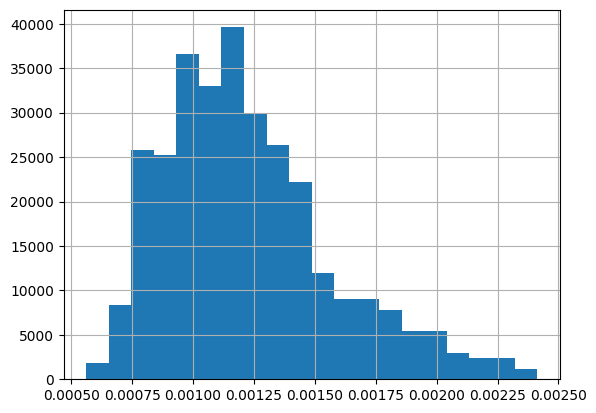

In [8]:
result_df['variances'].hist(bins = 20)

<AxesSubplot:>

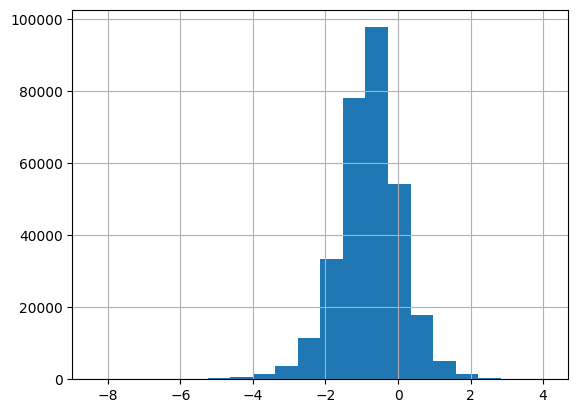

In [9]:
result_df['deepFMpredictions'].hist(bins = 20)

In [10]:
tqdm.pandas()

mu_variances = result_df['variances'].mean()
sigma_variances = result_df['variances'].std()

mu_deepFMscore = result_df['deepFMpredictions'].mean()
sigma_deepFMscore = result_df['deepFMpredictions'].std()

In [11]:
result_df['variances_rescaled'] = result_df['variances'].progress_apply(lambda x: ((x - mu_variances) / sigma_variances) * sigma_deepFMscore + mu_deepFMscore)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306600/306600 [00:00<00:00, 836883.51it/s]


<AxesSubplot:>

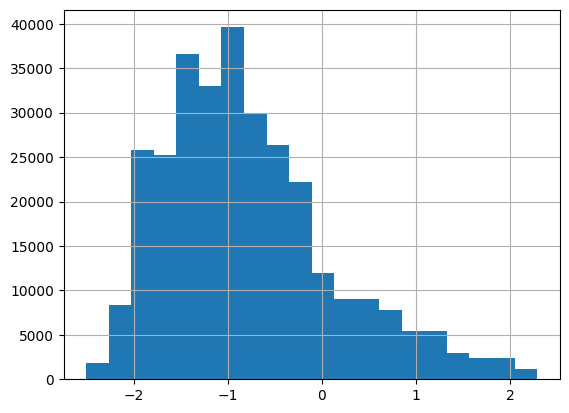

In [12]:
result_df['variances_rescaled'].hist(bins = 20)

In [13]:
result_df.groupby('popularity_category')['variances_rescaled'].mean()

popularity_category
High                  -0.795562
Low                   -0.789432
Medium                -0.783446
Negligible            -0.796485
Unmapped              -0.773906
Weekly New Releases   -0.798545
Name: variances_rescaled, dtype: float64

In [18]:
def evaluation_summary(df, alpha = 1, beta = 1, k_val = [1, 3, 5]):
    df['new_score'] = alpha * df['deepFMpredictions'] + beta * df['variances_rescaled']

    ndcg_results = result_df.groupby(['dw_p_ids', 'timestamps']).parallel_apply(
        lambda x: calculate_ndcg(x, predictions = 'new_score', labels = 'labels')
    ).reset_index(name=f'ndcg_score')
    ndcg_dict = pd.json_normalize(ndcg_results['ndcg_score']).mean().to_dict()
    
    print(f'NDCG for this approach : {ndcg_dict}')

    popularity_dist_dict = popularity_dist_at_rank(df.copy(), 'new_score', k_val = k_val)
    print(f'Popularity category distribution: {popularity_dist_dict}')
    
    catalog_dict = unique_catalog_at_rank(result_df, 'new_score', k_val = k_val)
    print(f'Catalog length distribution: {catalog_dict}')
    
    perplexity_at_k = perplexity_at_rank(result_df, 'new_score', k_val = k_val)
    print(f'Perplexity distribution: {perplexity_at_k}')
    
evaluation_summary(result_df, alpha=1, beta=0)

NDCG for this approach : {'NDCG@1': 0.376152388970743, 'NDCG@3': 0.5023452661306745, 'NDCG@5': 0.6167246150358874}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 11.67, 'Low': 31.7, 'Medium': 37.89, 'Negligible': 8.83, 'Unmapped': 0.01, 'Weekly New Releases': 9.89}, 'Popularity distribution @ 3': {'High': 8.31, 'Low': 36.68, 'Medium': 40.57, 'Negligible': 9.33, 'Unmapped': 0.02, 'Weekly New Releases': 5.09}, 'Popularity distribution @ 5': {'High': 6.83, 'Low': 39.89, 'Medium': 39.58, 'Negligible': 9.88, 'Unmapped': 0.02, 'Weekly New Releases': 3.8}}
Catalog length distribution: {'Catalog Length @ 1': 3580, 'Catalog Length @ 3': 5177, 'Catalog Length @ 5': 5874}
Perplexity distribution: {'Perplexity @ 1': 796.682787476886, 'Perplexity @ 3': 1431.265450639328, 'Perplexity @ 5': 1575.1172610262038}


In [19]:
evaluation_summary(result_df, alpha=0, beta=1)

NDCG for this approach : {'NDCG@1': 0.2653757103767628, 'NDCG@3': 0.4057892681219491, 'NDCG@5': 0.5427781831737751}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 6.31, 'Low': 41.43, 'Medium': 38.37, 'Negligible': 10.36, 'Unmapped': 0.03, 'Weekly New Releases': 3.5}, 'Popularity distribution @ 3': {'High': 6.39, 'Low': 41.33, 'Medium': 38.4, 'Negligible': 10.38, 'Unmapped': 0.02, 'Weekly New Releases': 3.47}, 'Popularity distribution @ 5': {'High': 6.38, 'Low': 41.27, 'Medium': 38.42, 'Negligible': 10.42, 'Unmapped': 0.02, 'Weekly New Releases': 3.49}}
Catalog length distribution: {'Catalog Length @ 1': 4262, 'Catalog Length @ 3': 5476, 'Catalog Length @ 5': 5973}
Perplexity distribution: {'Perplexity @ 1': 1495.1979914774458, 'Perplexity @ 3': 1498.4547962397633, 'Perplexity @ 5': 1512.3474228998605}


In [20]:
evaluation_summary(result_df, alpha=1, beta=1)

NDCG for this approach : {'NDCG@1': 0.33595032624710586, 'NDCG@3': 0.47264266905420116, 'NDCG@5': 0.594338126958978}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 9.46, 'Low': 35.27, 'Medium': 38.22, 'Negligible': 9.25, 'Unmapped': 0.02, 'Weekly New Releases': 7.78}, 'Popularity distribution @ 3': {'High': 7.81, 'Low': 38.19, 'Medium': 39.64, 'Negligible': 9.55, 'Unmapped': 0.02, 'Weekly New Releases': 4.8}, 'Popularity distribution @ 5': {'High': 6.72, 'Low': 40.34, 'Medium': 39.13, 'Negligible': 10.01, 'Unmapped': 0.02, 'Weekly New Releases': 3.77}}
Catalog length distribution: {'Catalog Length @ 1': 3949, 'Catalog Length @ 3': 5301, 'Catalog Length @ 5': 5905}
Perplexity distribution: {'Perplexity @ 1': 1079.5651991419722, 'Perplexity @ 3': 1438.173397784464, 'Perplexity @ 5': 1608.195694972463}


In [21]:
evaluation_summary(result_df, alpha=2, beta=1)

NDCG for this approach : {'NDCG@1': 0.3604925278888655, 'NDCG@3': 0.4906773634878683, 'NDCG@5': 0.6080567554822965}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 10.66, 'Low': 33.21, 'Medium': 38.09, 'Negligible': 8.93, 'Unmapped': 0.02, 'Weekly New Releases': 9.09}, 'Popularity distribution @ 3': {'High': 8.13, 'Low': 37.36, 'Medium': 40.09, 'Negligible': 9.43, 'Unmapped': 0.02, 'Weekly New Releases': 4.96}, 'Popularity distribution @ 5': {'High': 6.78, 'Low': 40.07, 'Medium': 39.39, 'Negligible': 9.94, 'Unmapped': 0.02, 'Weekly New Releases': 3.79}}
Catalog length distribution: {'Catalog Length @ 1': 3764, 'Catalog Length @ 3': 5236, 'Catalog Length @ 5': 5894}
Perplexity distribution: {'Perplexity @ 1': 916.610712398487, 'Perplexity @ 3': 1444.7297156843097, 'Perplexity @ 5': 1592.7501918515457}


In [22]:
evaluation_summary(result_df, alpha=1, beta=2)

NDCG for this approach : {'NDCG@1': 0.3074089665333614, 'NDCG@3': 0.4509913350348551, 'NDCG@5': 0.5771262907071949}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 8.02, 'Low': 38.0, 'Medium': 38.42, 'Negligible': 9.47, 'Unmapped': 0.02, 'Weekly New Releases': 6.07}, 'Popularity distribution @ 3': {'High': 7.37, 'Low': 39.21, 'Medium': 39.16, 'Negligible': 9.75, 'Unmapped': 0.02, 'Weekly New Releases': 4.48}, 'Popularity distribution @ 5': {'High': 6.64, 'Low': 40.61, 'Medium': 38.88, 'Negligible': 10.11, 'Unmapped': 0.02, 'Weekly New Releases': 3.73}}
Catalog length distribution: {'Catalog Length @ 1': 4082, 'Catalog Length @ 3': 5360, 'Catalog Length @ 5': 5921}
Perplexity distribution: {'Perplexity @ 1': 1255.7100289273583, 'Perplexity @ 3': 1438.424612986898, 'Perplexity @ 5': 1603.0266206959348}
